# Bitcoin and Ethereum price prediction with RNN LSTM


# Full Code

First things first, let’s import libraries which need for our project.

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gc

# import the relevant Keras modules
!pip install -q keras # this is not required if you are not using Google's colab
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

%matplotlib inline

Using TensorFlow backend.


In [0]:
neurons = 512                 # number of hidden units in the LSTM layer
activation_function = 'tanh'  # activation function for LSTM and Dense layer
loss = 'mae'                  # loss function for calculating the gradient, in this case Mean Absolute Error
optimizer="adam"              # optimizer for appljying gradient decent
dropout = 0.25                 # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 64               
epochs = 50                   
window_len = 7                # is an intiger to be used as the look back window for creating a single input sample.
training_size = 0.8           # porportion of data to be used for training
merge_date = '2016-01-01'     # the earliest date which we have data for both ETH and BTC or any other provided coin
split_date = '2017-09-01'     # split point for the training and test set according to the training size, this is used for plotting 

In [0]:
def get_market_data(market, tag=True):
  """
  market: the full name of the cryptocurrency as spelled on coinmarketcap.com. eg.: 'bitcoin'
  tag: eg.: 'btc', if provided it will add a tag to the name of every column.
  returns: panda DataFrame
  This function will use the coinmarketcap.com url for provided coin/token page. 
  Reads the OHLCV and Market Cap.
  Converts the date format to be readable. 
  Makes sure that the data is consistant by converting non_numeric values to a number very close to 0.
  And finally tags each columns if provided.
  """
  market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
  if tag:
    market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
  return market_data


def merge_data(a, b, from_date=merge_date):
  """
  a: first DataFrame
  b: second DataFrame
  from_date: includes the data from the provided date and drops the any data before that date.
  returns merged data as Pandas DataFrame
  """
  merged_data = pd.merge(a, b, on=['Date'])
  merged_data = merged_data[merged_data['Date'] >= from_date]
  return merged_data


def add_volatility(data, coins=['btc', 'eth']):
  """
  data: input data, pandas DataFrame
  coins: default is for 'btc and 'eth'. It could be changed as needed
  This function calculates the volatility and close_off_high of each given coin in 24 hours, 
  and adds the result as new columns to the DataFrame.
  Return: DataFrame with added columns
  """
  for coin in coins:
    # calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
             coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
  return data


def create_model_data(data):
  """
  data: pandas DataFrame
  This function drops unnecessary columns and reverses the order of DataFrame based on decending dates.
  Return: pandas DataFrame
  """
  data = data[['Date']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume','close_off_high','volatility']]]
  data = data.sort_values(by='Date')
  return data


def split_data(data, training_size=0.8):
  """
  data: Pandas Dataframe
  training_size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, coins=['btc', 'eth'], window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coins: coin datas which will be used as the input. Default is 'btc', 'eth'
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
  Return: X, the input for our model as a python list which later needs to be converted to numpy array.
  """
  norm_cols = [coin + metric for coin in coins for metric in ['_Close', '_Volume']]
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs


def create_outputs(data, coin, window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coin: the target coin in which we need to create the output labels for
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create the labels array for our training and validation and normalize it between 0 and 1
  Return: Normalized numpy array for 'Close' prices of the given coin
  """
  return (data[coin + '_Close'][window_len:].values / data[coin + '_Close'][:-window_len].values) - 1


def to_array(data):
  """
  data: DataFrame
  This function will convert list of inputs to a numpy array
  Return: numpy array
  """
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)


def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 2.5
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer)
  model.summary()
  return model

In [0]:
def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()

In [0]:
btc_data = get_market_data("bitcoin", tag='btc')
eth_data = get_market_data("ethereum", tag='eth')

In [6]:
btc_data.head()

,Date,btc_Open,btc_High,btc_Low,btc_Close,btc_Volume,btc_Market Cap
0,2018-02-25,9796.42,9923.22,9407.06,9664.73,5.706940e+09,165407000000
1,2018-02-24,10287.70,10597.20,9546.97,9813.07,6.917930e+09,173682000000
2,2018-02-23,9937.07,10487.30,9734.56,10301.10,7.739500e+09,167746000000
3,2018-02-22,10660.40,11039.10,9939.09,10005.00,8.040080e+09,179936000000
4,2018-02-21,11372.20,11418.50,10479.10,10690.40,9.405340e+09,191927000000


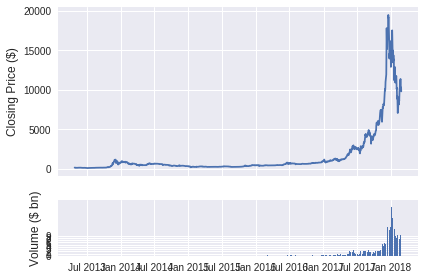

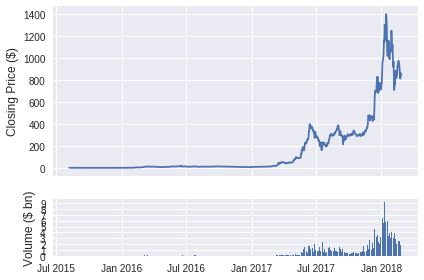

In [7]:
show_plot(btc_data, tag='btc')
show_plot(eth_data, tag='eth')

In [0]:
market_data = merge_data(btc_data, eth_data)
market_data = add_volatility(market_data)
model_data = create_model_data(market_data)
train_set, test_set = split_data(model_data)

In [11]:
model_data.tail()

,Date,btc_Close,btc_Volume,btc_close_off_high,btc_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
4,2018-02-21,10690.40,9.405340e+09,0.550138,0.082605,849.97,2531730000,0.525544,0.091508
3,2018-02-22,10005.00,8.040080e+09,0.880165,0.103187,812.85,2150370000,0.722086,0.086263
2,2018-02-23,10301.10,7.739500e+09,-0.505274,0.075751,864.19,2334820000,-0.516443,0.112779
1,2018-02-24,9813.07,6.917930e+09,0.493254,0.102086,840.51,1926580000,0.279764,0.070776
0,2018-02-25,9664.73,5.706940e+09,0.001589,0.052689,844.81,1646960000,-0.457914,0.036655


In [12]:
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set, coin='btc')
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set, coin='btc')

Y_train_eth = create_outputs(train_set, coin='eth')
Y_test_eth = create_outputs(test_set, coin='eth')

X_train, X_test = to_array(X_train), to_array(X_test)

print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_btc), np.shape(Y_test_btc))
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_eth), np.shape(Y_test_eth))

(622, 7, 8) (151, 7, 8) (622,) (151,)
(622, 7, 8) (151, 7, 8) (622,) (151,)


In [13]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 512)            1067008   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
__________

622/622 [==============================] - 1s 1ms/step - loss: 0.0425 - val_loss: 0.0819
Epoch 7/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0354 - val_loss: 0.0702
Epoch 8/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0357 - val_loss: 0.0657
Epoch 9/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0346 - val_loss: 0.0648
Epoch 10/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0318 - val_loss: 0.0610
Epoch 11/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0301 - val_loss: 0.0608
Epoch 12/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0304 - val_loss: 0.0682
Epoch 13/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0308 - val_loss: 0.0585
Epoch 14/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0300 - val_loss: 0.0578
Epoch 15/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0302 - val_loss: 0.0564
Epoch

622/622 [==============================] - 1s 1ms/step - loss: 0.0290 - val_loss: 0.0588
Epoch 20/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0286 - val_loss: 0.0581
Epoch 21/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0299 - val_loss: 0.0538
Epoch 22/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0288 - val_loss: 0.0623
Epoch 23/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0281 - val_loss: 0.0530
Epoch 24/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0270 - val_loss: 0.0546
Epoch 25/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0258 - val_loss: 0.0519
Epoch 26/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0271 - val_loss: 0.0531
Epoch 27/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0267 - val_loss: 0.0514
Epoch 28/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0262 - val_loss: 0.0509
Ep

622/622 [==============================] - 1s 1ms/step - loss: 0.0264 - val_loss: 0.0534
Epoch 33/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0267 - val_loss: 0.0565
Epoch 34/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0277 - val_loss: 0.0526
Epoch 35/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0253 - val_loss: 0.0507
Epoch 36/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0256 - val_loss: 0.0511
Epoch 37/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0260 - val_loss: 0.0517
Epoch 38/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0251 - val_loss: 0.0511
Epoch 39/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0248 - val_loss: 0.0529
Epoch 40/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0251 - val_loss: 0.0534
Epoch 41/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0268 - val_loss: 0.0516
Ep

622/622 [==============================] - 1s 1ms/step - loss: 0.0256 - val_loss: 0.0504
Epoch 46/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0256 - val_loss: 0.0500
Epoch 47/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0249 - val_loss: 0.0508
Epoch 48/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0242 - val_loss: 0.0512
Epoch 49/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0245 - val_loss: 0.0513
Epoch 50/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0269 - val_loss: 0.0561


In [14]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
eth_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
eth_history = eth_model.fit(X_train, Y_train_eth, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_eth), shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 512)            1067008   
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
__________

622/622 [==============================] - 1s 1ms/step - loss: 0.0704 - val_loss: 0.0579
Epoch 7/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0693 - val_loss: 0.0522
Epoch 8/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0664 - val_loss: 0.0548
Epoch 9/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0665 - val_loss: 0.0586
Epoch 10/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0703 - val_loss: 0.0506
Epoch 11/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0675 - val_loss: 0.0534
Epoch 12/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0635 - val_loss: 0.0488
Epoch 13/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0659 - val_loss: 0.0522
Epoch 14/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0658 - val_loss: 0.0526
Epoch 15/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0647 - val_loss: 0.0481
Epoch

622/622 [==============================] - 1s 1ms/step - loss: 0.0617 - val_loss: 0.0518
Epoch 20/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0650 - val_loss: 0.0506
Epoch 21/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0611 - val_loss: 0.0528
Epoch 22/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0603 - val_loss: 0.0499
Epoch 23/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0608 - val_loss: 0.0501
Epoch 24/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0581 - val_loss: 0.0488
Epoch 25/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0577 - val_loss: 0.0473
Epoch 26/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0590 - val_loss: 0.0468
Epoch 27/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0589 - val_loss: 0.0487
Epoch 28/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0613 - val_loss: 0.0497
Ep

622/622 [==============================] - 1s 1ms/step - loss: 0.0598 - val_loss: 0.0468
Epoch 33/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0567 - val_loss: 0.0511
Epoch 34/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0618 - val_loss: 0.0477
Epoch 35/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0600 - val_loss: 0.0517
Epoch 36/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0614 - val_loss: 0.0514
Epoch 37/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0574 - val_loss: 0.0496
Epoch 38/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0585 - val_loss: 0.0490
Epoch 39/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0597 - val_loss: 0.0477
Epoch 40/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0571 - val_loss: 0.0468
Epoch 41/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0599 - val_loss: 0.0484
Ep

622/622 [==============================] - 1s 1ms/step - loss: 0.0589 - val_loss: 0.0544
Epoch 46/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0581 - val_loss: 0.0476
Epoch 47/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0559 - val_loss: 0.0473
Epoch 48/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0568 - val_loss: 0.0494
Epoch 49/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0568 - val_loss: 0.0499
Epoch 50/50
622/622 [==============================] - 1s 1ms/step - loss: 0.0582 - val_loss: 0.0497


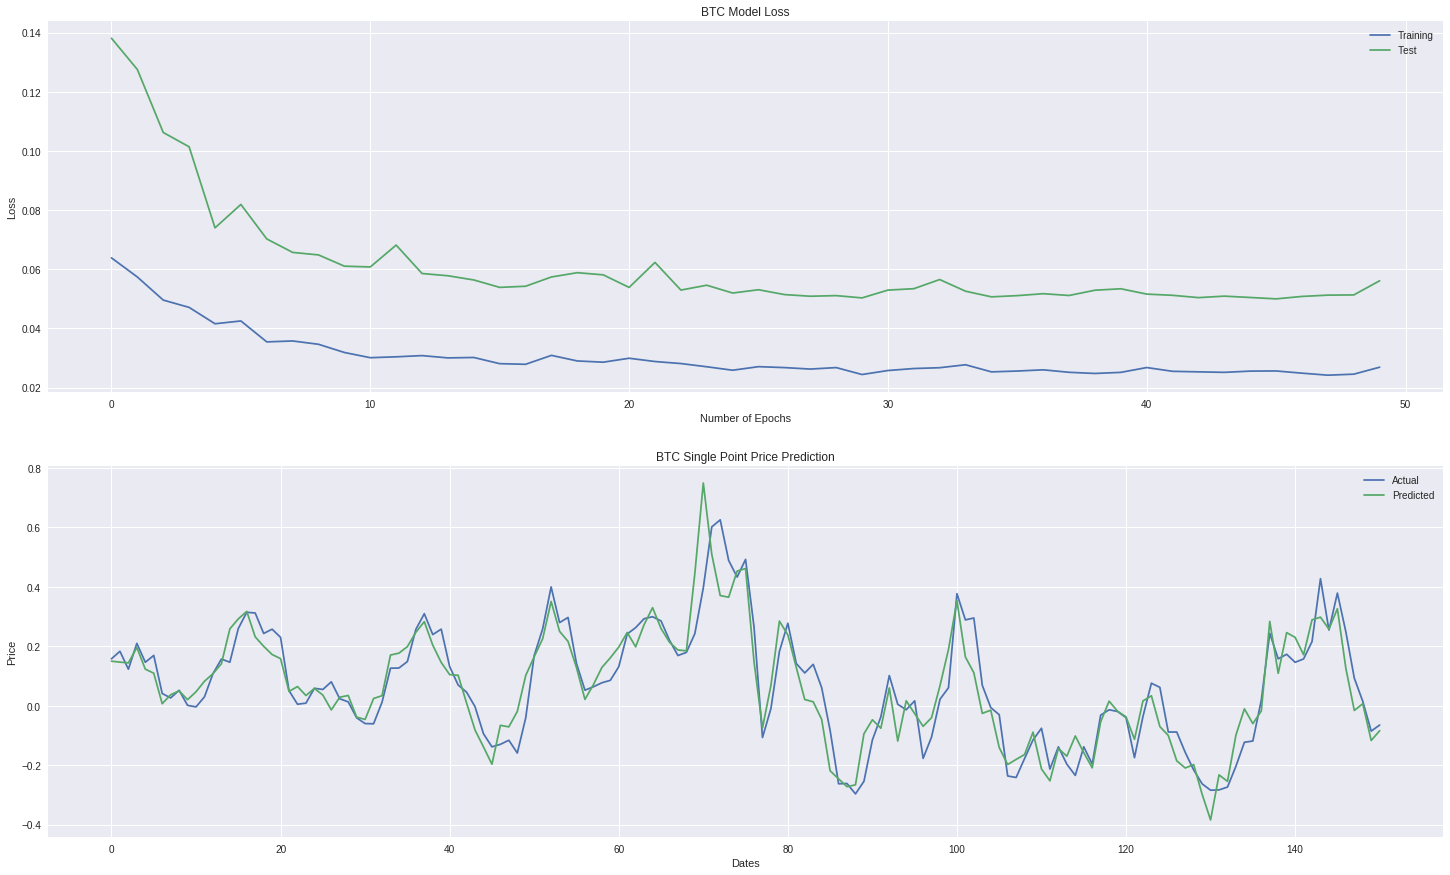

In [15]:
plt.figure(figsize=(25, 15))
plt.subplot(211)
plt.plot(btc_history.epoch, btc_history.history['loss'], )
plt.plot(btc_history.epoch, btc_history.history['val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('BTC Model Loss')
plt.legend(['Training', 'Test'])

plt.subplot(212)
plt.plot(btc_model.predict(X_test))
plt.plot(Y_test_btc)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('BTC Single Point Price Prediction')
plt.legend(['Actual', 'Predicted'])
plt.show()

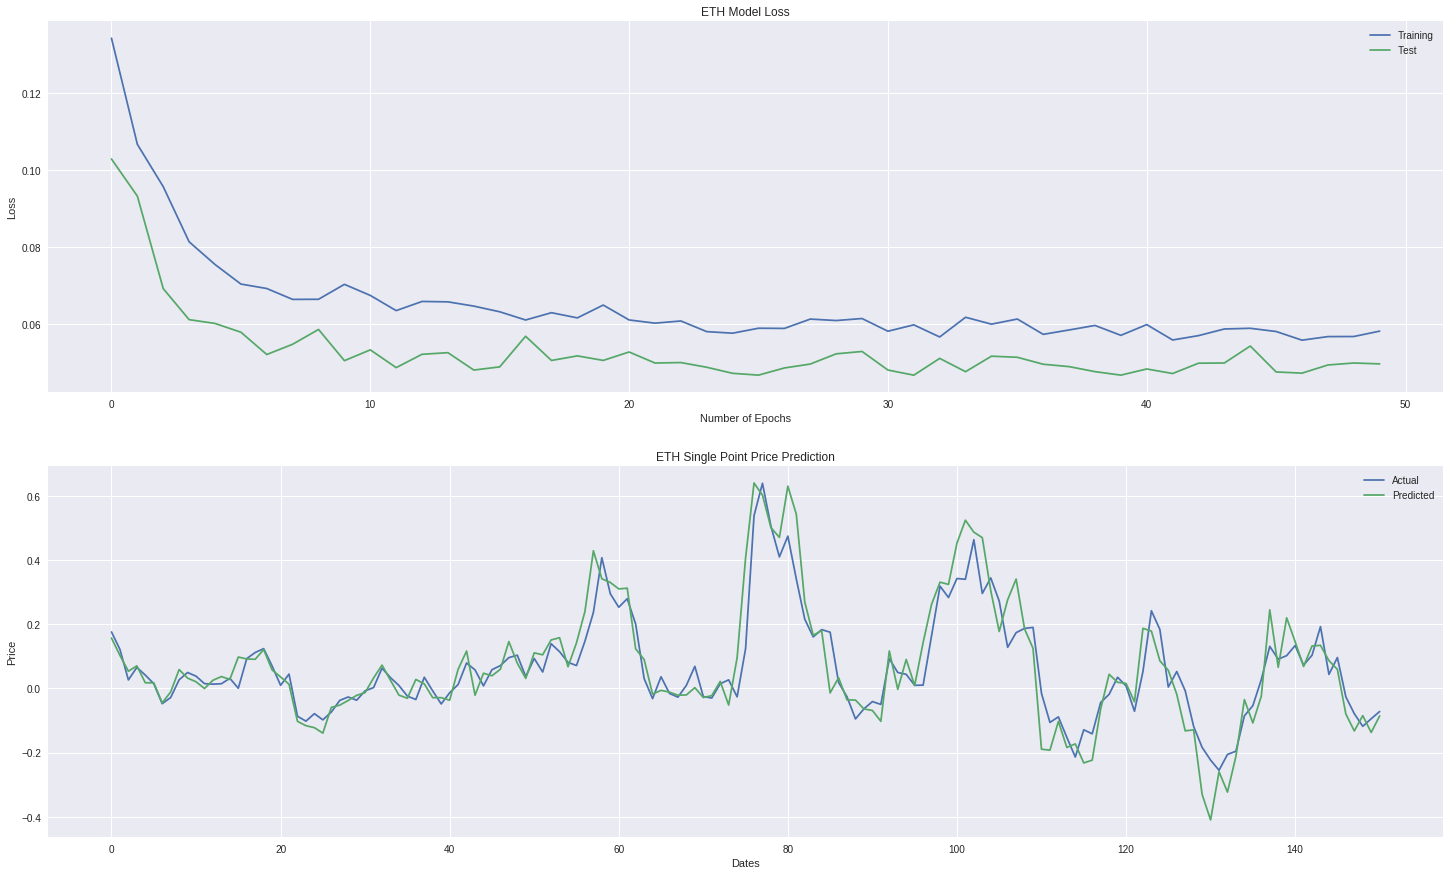

In [16]:
plt.figure(figsize=(25, 15)) 
plt.subplot(211)
plt.plot(eth_history.epoch, eth_history.history['loss'], )
plt.plot(eth_history.epoch, eth_history.history['val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('ETH Model Loss')
plt.legend(['Training', 'Test'])
plt.subplot(212)
plt.plot(eth_model.predict(X_test))
plt.plot(Y_test_eth)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('ETH Single Point Price Prediction')
plt.legend(['Actual', 'Predicted'])
plt.show()